# Multiclass classification with GPflow

In [131]:
import GPflow
import tensorflow as tf
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
plt = matplotlib.pyplot

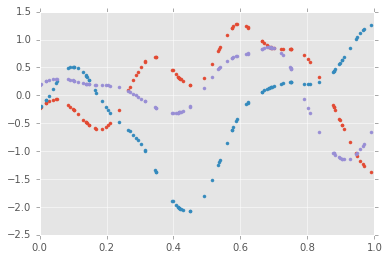

In [132]:
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))

plt.plot(X, f, '.')

In [133]:
Y = np.argmax(f, 1).reshape(-1,1)

In [134]:
m = GPflow.svgp.SVGP(X, Y, 
                     kern=GPflow.kernels.Matern32(1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=GPflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

In [135]:

m.likelihood.num_gauss_hermite_points = 4
m.kern.white.variance.fixed = True
m.Z.fixed = True
_ = m.optimize()


compiling tensorflow function...
done
optimization terminated, setting model state


In [171]:
def plot(m):
    f = plt.figure()
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.min(), m.X.max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X[m.Y.flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

    

compiling tensorflow function...
done
compiling tensorflow function...
done


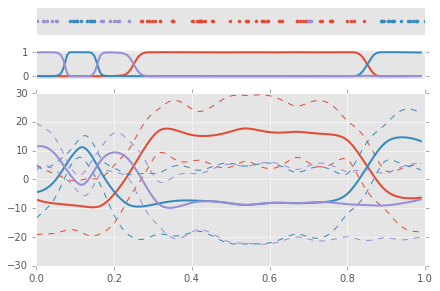

In [137]:
plot(m)

In [138]:
print m.kern

kern.white.variance transform:+ve prior:None [FIXED]
[ 0.01]
kern.matern32.variance transform:+ve prior:None
[ 80.58923789]
kern.matern32.lengthscales transform:+ve prior:None
[ 0.10428678]


In [153]:
m = GPflow.sgpmc.SGPMC(X, Y, 
                     kern=GPflow.kernels.Matern32(1, lengthscales=0.1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=GPflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)

In [154]:
m.kern.matern32.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.matern32.lengthscales.prior = GPflow.priors.Gamma(2.,2.)
m.kern.white.variance.fixed = True

In [155]:
_ = m.optimize(max_iters=10)

compiling tensorflow function...
done
optimization terminated, setting model state


compiling tensorflow function...
done
compiling tensorflow function...
done


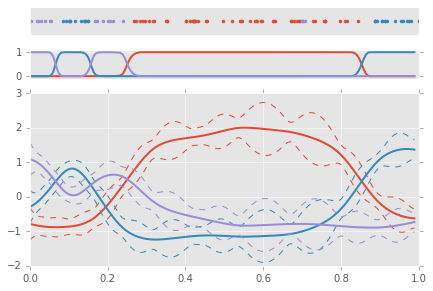

In [156]:
plot(m)

In [159]:
samples = m.sample(500, verbose=True, epsilon=0.04, Lmax=15)

Iteration:  100 	 Acc Rate:  86.0 %
Iteration:  200 	 Acc Rate:  86.0 %
Iteration:  300 	 Acc Rate:  68.0 %
Iteration:  400 	 Acc Rate:  83.0 %
Iteration:  500 	 Acc Rate:  47.0 %


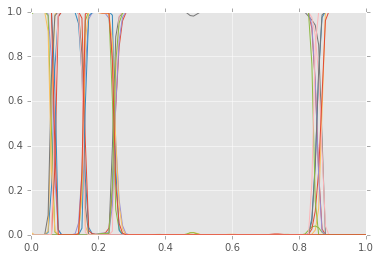

In [186]:
xx = np.linspace(0, 1, 100)[:,None]
for s in samples[::100]:
    m.set_state(s)
    #plot(m)
    plt.plot(xx, m.predict_y(xx)[0])

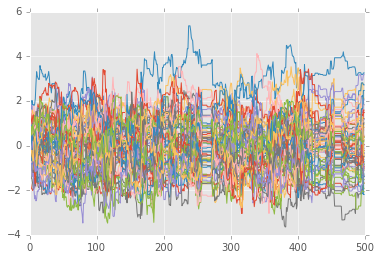

In [161]:
plt.plot(samples)

In [166]:
l = []
for s in samples:
    m.set_state(s)
    l.append(m.kern.matern32.lengthscales._array.copy())
    

In [169]:
l = np.vstack(l)

(array([  1.,   2.,   3.,   3.,   0.,   7.,   2.,   3.,  13.,   5.,   2.,
          6.,   6.,  16.,  21.,  23.,  23.,  24.,  26.,  28.,  25.,  21.,
         20.,  16.,   8.,  16.,  26.,  19.,  17.,   8.,  10.,   7.,   8.,
         12.,   4.,   6.,   6.,   6.,   4.,   9.,   5.,   5.,   6.,   1.,
          2.,   7.,   0.,   4.,   0.,   8.]),
 array([ 0.09154716,  0.09450921,  0.09747125,  0.1004333 ,  0.10339535,
         0.1063574 ,  0.10931945,  0.1122815 ,  0.11524355,  0.1182056 ,
         0.12116765,  0.1241297 ,  0.12709174,  0.13005379,  0.13301584,
         0.13597789,  0.13893994,  0.14190199,  0.14486404,  0.14782609,
         0.15078814,  0.15375018,  0.15671223,  0.15967428,  0.16263633,
         0.16559838,  0.16856043,  0.17152248,  0.17448453,  0.17744658,
         0.18040862,  0.18337067,  0.18633272,  0.18929477,  0.19225682,
         0.19521887,  0.19818092,  0.20114297,  0.20410502,  0.20706707,
         0.21002911,  0.21299116,  0.21595321,  0.21891526,  0.22187731,
 

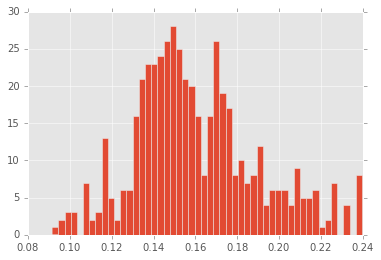

In [170]:
plt.hist(l, 50)